In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')
%matplotlib inline

# Data Loading and Exploration

In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv', parse_dates=['Dates'])
test_df = pd.read_csv('test.csv', parse_dates=['Dates'], index_col='Id')

print("--- Training Data ---")
print(train_df.head())
print("\n--- Test Data ---")
print(test_df.head())

--- Training Data ---
                Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.8008

In [3]:
# Check data info and for missing values
print("--- Training Data Info ---")
train_df.info()

print("\n--- Test Data Info ---")
test_df.info()

# Note: No missing values in the relevant columns, which simplifies preprocessing.

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   Descript    878049 non-null  object        
 3   DayOfWeek   878049 non-null  object        
 4   PdDistrict  878049 non-null  object        
 5   Resolution  878049 non-null  object        
 6   Address     878049 non-null  object        
 7   X           878049 non-null  float64       
 8   Y           878049 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB

--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 884262 entries, 0 to 884261
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       884262 n

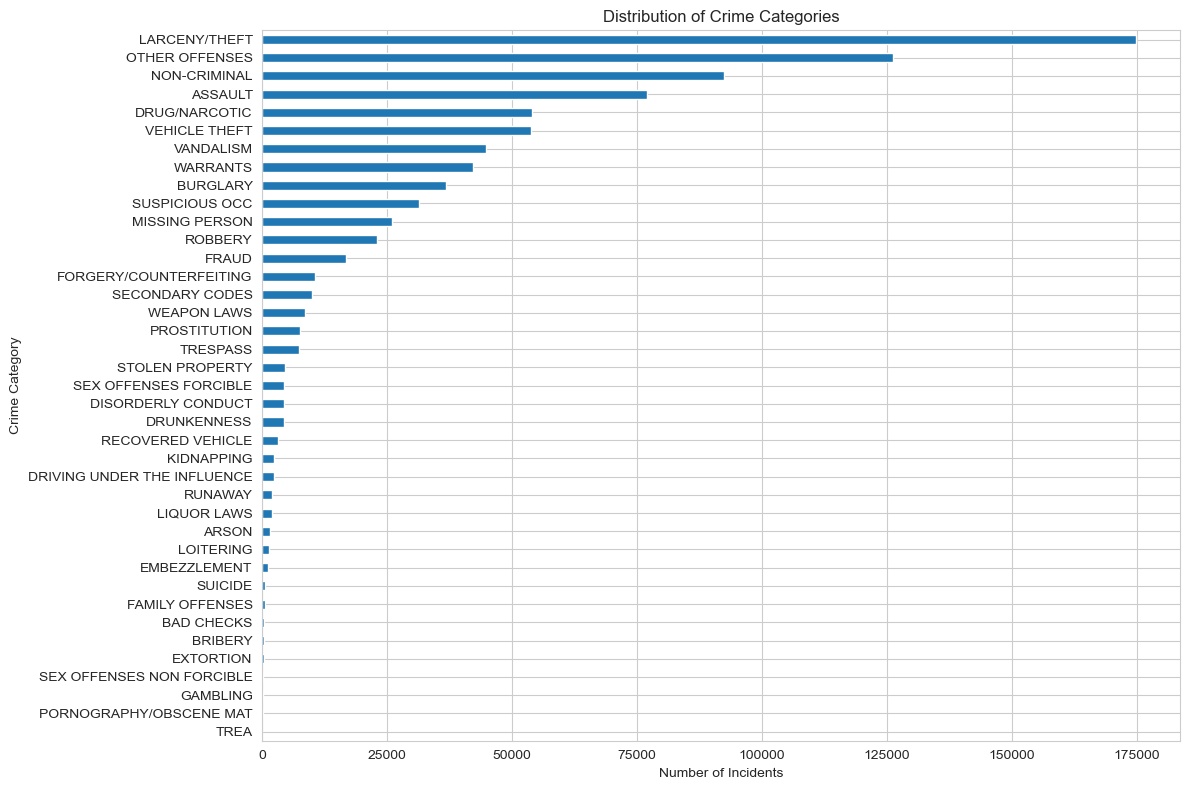

In [4]:
# Analyze the target variable: Category
plt.figure(figsize=(12, 8))
crime_counts = train_df['Category'].value_counts().sort_values(ascending=True)
crime_counts.plot(kind='barh')
plt.title('Distribution of Crime Categories')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Category')
plt.tight_layout()
plt.show()

# The dataset is highly imbalanced. 'LARCENY/THEFT' is the most common crime,
# while others like 'TREA' are very rare.

# Feature Engineering

In [5]:
def feature_engineer(df):
    """
    Engineers features for the SF Crime dataset.
    """
    # 1. Extract time-based features from 'Dates'
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['DayOfWeek'] = df['Dates'].dt.dayofweek # Monday=0, Sunday=6
    df['WeekOfYear'] = df['Dates'].dt.isocalendar().week.astype(int)

    # 2. Create cyclical features for time to capture periodic patterns
    # These help models understand that hour 23 is close to hour 0.
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/23.0)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/23.0)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)

    # 3. Engineer Address features
    # A simple but effective feature is to check if the crime occurred at an intersection.
    df['IsIntersection'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)

    # 4. Clean up GPS Coordinates (X, Y)
    # The dataset contains some clear outliers where Y=90.0
    # We will replace these with the median of the valid coordinates.
    df.loc[df['Y'] == 90.0, 'X'] = df[df['Y'] != 90.0]['X'].median()
    df.loc[df['Y'] == 90.0, 'Y'] = df[df['Y'] != 90.0]['Y'].median()

    return df

# Apply feature engineering to both training and test sets
print("Engineering features for the training set...")
train_df_featured = feature_engineer(train_df)

print("Engineering features for the test set...")
test_df_featured = feature_engineer(test_df)

print("\n--- Featured Training Data ---")
print(train_df_featured.head())

Engineering features for the training set...
Engineering features for the test set...

--- Featured Training Data ---
                Dates        Category                      Descript  \
0 2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1 2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2 2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4 2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0          2   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1          2   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2          2   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3          2   NORTHERN            NONE   1500 Block of LOMBARD ST   
4          2       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  Year  Mo

# Data Preprocessing

In [6]:
# Encode the categorical target variable
category_encoder = LabelEncoder()
train_df_featured['CategoryEncoded'] = category_encoder.fit_transform(train_df_featured['Category'])

# One-Hot Encode the 'PdDistrict' feature
train_df_processed = pd.get_dummies(train_df_featured, columns=['PdDistrict'], dtype=int)
test_df_processed = pd.get_dummies(test_df_featured, columns=['PdDistrict'], dtype=int)

# Define the features to be used by the model
features = [
    'X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek',
    'WeekOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'IsIntersection'
]
# Add the one-hot encoded district columns to the features list
district_cols = [col for col in train_df_processed.columns if col.startswith('PdDistrict_')]
features.extend(district_cols)

# Align columns between train and test set (in case a district is missing in one set)
train_labels = train_df_processed['CategoryEncoded']
train_ids = train_df.index

# Drop columns that won't be used
drop_cols = ['Category', 'CategoryEncoded', 'Descript', 'Resolution', 'Address', 'Dates']
train_df_final = train_df_processed.drop(columns=drop_cols, errors='ignore')
test_df_final = test_df_processed.drop(columns=['Address', 'Dates'], errors='ignore')

# Ensure both dataframes have the same feature columns in the same order
train_features, test_features = train_df_final.align(test_df_final, join='inner', axis=1)

print(f"Number of features: {len(train_features.columns)}")
print("Final features:", train_features.columns.tolist())

Number of features: 24
Final features: ['DayOfWeek', 'X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'WeekOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'IsIntersection', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN']


# Model Training (XGBoost)

In [7]:
# XGBoost Classifier parameters
# These parameters are a good starting point and can be tuned for better performance.
params = {
    'objective': 'multi:softprob',
    'num_class': len(category_encoder.classes_),
    'eval_metric': 'mlogloss',
    'eta': 0.1,  # learning_rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'n_estimators': 300,
    'tree_method': 'hist', # Use 'gpu_hist' if you have a GPU for massive speedup
    'early_stopping_rounds': 20
}

# Split the data to create a validation set for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels # Stratify to maintain class distribution
)

# Initialize and train the XGBoost model
print("Training XGBoost model...")
model = xgb.XGBClassifier(**params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50 # Print evaluation results every 50 rounds
)
print("\nModel training complete!")

Training XGBoost model...
[0]	validation_0-mlogloss:3.43795
[50]	validation_0-mlogloss:2.33452
[100]	validation_0-mlogloss:2.28215
[150]	validation_0-mlogloss:2.26522
[200]	validation_0-mlogloss:2.25501
[250]	validation_0-mlogloss:2.24803
[299]	validation_0-mlogloss:2.24329

Model training complete!


# Prediction

In [8]:
# Make predictions on the test set
print("Making predictions on the test set...")
predictions = model.predict_proba(test_features)
print("Prediction complete!")

# Create the submission DataFrame
submission_df = pd.DataFrame(predictions, columns=category_encoder.classes_, index=test_features.index)

# Format the submission file
submission_df.to_csv('submission_cc.csv', index_label='Id')

print("\n--- Submission File Head ---")
print(submission_df.head())
print("\nSubmission file 'submission_cc.csv' created successfully! ")

Making predictions on the test set...
Prediction complete!

--- Submission File Head ---
       ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
Id                                                                           
0   0.002075  0.112913    0.000008  0.000053  0.022248            0.001134   
1   0.002205  0.044232    0.000006  0.000079  0.001553            0.001165   
2   0.011103  0.164695    0.000058  0.000179  0.082768            0.000942   
3   0.007029  0.181471    0.000011  0.001344  0.034725            0.002589   
4   0.007029  0.181471    0.000011  0.001344  0.034725            0.002589   

    DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  EMBEZZLEMENT  \
Id                                                                          
0                      0.006364       0.021500     0.001956      0.000880   
1                      0.013102       0.072539     0.002763      0.000133   
2                      0.000965       0.014708     0.007